In [52]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

# Finding Pulse Sequence

### Setting beginning and ending states
### setting desired U value

In [58]:
qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
startingstate=tensor(qubit1state,qubit1state) #initial state
endingstate= tensor(basis(3,2),basis(3,2))
startingstate.dims=[[9],[1]]
endingstate.dims=[[9],[1]]
print (startingstate)
print (endingstate)

U=endingstate * startingstate.dag()
U.dims=[[9],[9]]
U

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]

## Defining 3x3 pauli spin matrices 
## Definiting number of iterations
## Defining H_ops

In [59]:

R = 150 #GRAPE itterations

T = 1
times = np.linspace(0, T, 100)


#wirting our terms so I can actually read the hamiltonian
#Nuc terms are second qubit
#Elec qubit is first qubit
nuclear_spin = 1
electron_spin = 1

sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'y')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN
identity3 = identity(3) #3x3 identity matrix



#Creating operators that can be tuned in the Hamiltonian via the control fields, list is below called H_ops

H_opsEx=tensor(sigmaxE, identity3)
H_opsEy=tensor(sigmayE, identity3)
H_opsEz=tensor(sigmazE, identity3)

H_opsNx=tensor(identity3, sigmaxN)
H_opsNy=tensor(identity3, sigmayN)
H_opsNz=tensor(identity3, sigmazN)

H_opsENx = tensor(sigmaxE, sigmaxN)
H_opsENy = tensor(sigmayE, sigmayN)           
H_opsENz = tensor(sigmazE, sigmazN)


#changing dims bc qutip is silly

H_opsEx.dims=[[9],[9]]
H_opsEy.dims=[[9],[9]]
H_opsEz.dims=[[9],[9]]

H_opsNx.dims=[[9],[9]]
H_opsNy.dims=[[9],[9]]
H_opsNz.dims=[[9],[9]]

H_opsENx.dims=[[9],[9]]
H_opsENy.dims=[[9],[9]]
H_opsENz.dims=[[9],[9]] 


#making H_ops list           
H_ops = [H_opsEx, H_opsEy, H_opsEz, H_opsNx, H_opsNy, H_opsNz, H_opsENx, H_opsENy, H_opsENz]            
               
               
#making labels for pulse sequence graphs
H_labels = [r'$uE_{x}$',
            r'$uE_{y}$',
            r'$uE_{z}$',
            r'$uN_{x}$',
            r'$uN_{y}$',
            r'$uN_{z}$',
            r'$uEN_{x}$',
            r'$uEN_{y}$',
            r'$uEN_{z}$']


# Defining hamiltonian and constants 

In [60]:
#defining hamiltonian for NV center

#constants

f_fine_structure = 2.87e9
f_nuclear_quadrupole = -5.01e6
f_axial_magnetic_hyperfine = -2.14E6
f_transverse_magnetic_hyperfine = -2.7E6
g_factor_electron = 2.0028
gyromagnetic_constant_nuclear = 1.93297E7 / (2 * np.pi)
uB = physical_constants['Bohr magneton'][0]
uN = physical_constants['nuclear magneton'][0]    
bvector=[0,0,1]





#witing out hamiltonian terms

H1 = f_fine_structure * tensor((sigmazEsquared-(2/3)*identity3),identity3)

H2 = f_axial_magnetic_hyperfine * tensor(sigmazE,sigmazN) 

#H3 = f_transverse_magnetic_hyperfine * (tensor(sigmaxE,sigmaxN)+tensor(sigmayE,sigmayN))

#H4 = f_nuclear_quadrupole * tensor(tensor(identity3), (sigmazNsquared-(2/3)*identity3))

#H5 = (uB * g_factor_electron) * tensor((sigmaxE*bvector[0] + sigmayE*bvector[1] + sigmazE*bvector[2]), identity3)

#H6 = gyromagnetic_constant_nuclear * tensor(identity3,(sigmaxN*bvector[0] + sigmayN*bvector[1] + sigmazN*bvector[2]))
          
    
H0= H1 #+H2+H3+H4+H5+H6
H0.dims=[[9],[9]] #changing dimensions bc dot products are silly
H0 #hamiltonian without b field term



Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 9.56666667e+08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  9.56666667e+08  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.56666667e+08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.91333333e+09
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.91333333e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.91333333e+09  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0

# Plot pulses

In [61]:
##creating initial control pulse values as starting guess for GRAPE

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]


In [62]:
#doing GRAPE!

result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2 * pi / T, phase_sensitive=True,
                          progress_bar=TextProgressBar())

10.0%. Run time:  11.31s. Est. time left: 00:00:01:41
20.0%. Run time:  21.89s. Est. time left: 00:00:01:27
30.0%. Run time:  32.32s. Est. time left: 00:00:01:15
40.0%. Run time:  42.76s. Est. time left: 00:00:01:04
50.0%. Run time:  53.21s. Est. time left: 00:00:00:53
60.0%. Run time:  63.64s. Est. time left: 00:00:00:42
70.0%. Run time:  74.11s. Est. time left: 00:00:00:31
80.0%. Run time:  85.41s. Est. time left: 00:00:00:21
90.0%. Run time:  96.30s. Est. time left: 00:00:00:10
Total run time: 106.02s


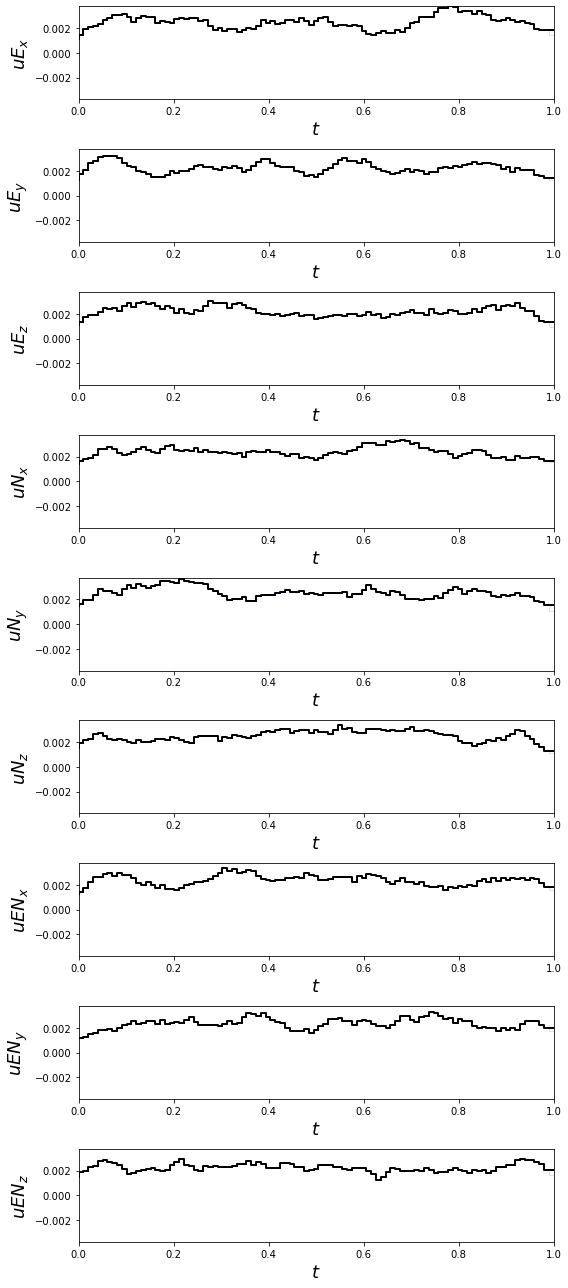

In [63]:
plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.show()

# Calcuate overlap (is this fidelity?)

In [64]:
idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [65]:
result.U_f.tidyup(1e-2)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.78368086+0.62022662j -0.01888226-0.02839682j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.03197529+0.01185327j  0.78322438+0.6198659j  -0.01888225-0.02839682j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.03197528+0.01185328j  0.78368032+0.62022729j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.20268172-0.9789293j  -0.01489197+0.01988662j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j

In [66]:
realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.78368086+0.62022662j]
 [0.03197529+0.01185327j]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]]


In [67]:
idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.99883674+0.j         0.03241013+0.01054275j 0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.03241013-0.01054275j 0.00116292+0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.

0.0

# Plotting City Scape


In [55]:
#plotting cityscape for real density matrix
dm=np.array(densitymatrix)
print (dm)
plot_state_city(dm, title='State Tomography for Real State')

[[ 0.15081582+0.j          0.14160228+0.02722125j -0.17380785-0.06234141j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.18205341-0.05762696j  0.        +0.j          0.18229072-0.05905361j]
 [ 0.14160228-0.02722125j  0.13786487+0.j         -0.17444192-0.02716173j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.16053025-0.08696588j  0.        +0.j          0.16049556-0.0883482j ]
 [-0.17380785+0.06234141j -0.17444192+0.02716173j  0.22607457+0.j
   0.        +0.j          0.        +0.j          0.        +0.j
  -0.1859869 +0.14166607j  0.        +0.j         -0.18567067+0.1434083j ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j       

VisualizationError: 'Input is not a multi-qubit quantum state.'

In [56]:
#plotting cityscape for ideal density matrix
idm=np.array(idealdensitymatrix)
print (idm)
plot_state_city(idm, title='State Tomography for Ideal State')

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


VisualizationError: 'Input is not a multi-qubit quantum state.'